# Chest X-Ray Classification

![normal vs pneumonia](https://www.bmj.com/content/bmj/370/bmj.m2426/F4.large.jpg?width=800&height=600)
<a href="https://www.bmj.com/content/370/bmj.m2426">Normal VS Pneumonia</a>

### "Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it.

### The infection causes inflammation in the air sacs in your lungs, which are called alveoli. The alveoli fill with fluid or pus, making it difficult to breathe.

### Pneumonia symptoms can be mild to life-threatening. They can include:

<ul>
    <li>coughing that may produce phlegm (mucus)</li>
    <li>fever</li>
    <li>sweating or chills</li>
    <li>shortness of breath that happens while doing normal activities or even while resting</li>
    <li>chest pain that’s worse when you breathe or cough</li>
    <li>feelings of tiredness or fatigue</li>
    <li>loss of appetite</li>
    <li>nausea or vomiting</li>
    <li>headaches"</li>
</ul>
<a href="http://www.healthline.com/health/pneumonia">Source</a>

# Contents<a id="contents"></a>
### [Useful Libraies](#library)
### [Understanding The Data](#understand)
### [Data Generator](#generator)
### [Model](#model)
### [Results](#results)

# Useful Libraries<a id = "library"></a>
#### [Return2Contents](#contents)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2 as cv

from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.applications import DenseNet169
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Understanding The Data <a id = "understand" ></a>
#### [Return2Contents](#contents)

In [2]:
base_dir = "../input/chest-xray-pneumonia/chest_xray/"

train_dir = base_dir + "train/"
val_dir = base_dir +"val/"
test_dir = base_dir +"test/"

In [3]:
directories = [train_dir, val_dir, test_dir]
labels = ["NORMAL", "PNEUMONIA"]
normal = pneumonia = train = test = val = 0

In [4]:
for dr in directories:
    
    for lbl in labels:
        
        path = os.path.join(dr, lbl)
        length = len(os.listdir(path))
        
        if dr == train_dir:
            train += length        
            if lbl == "NORMAL":
                normal += length
            else:
                pneumonia += length
                
        elif dr == test_dir:
            test += length
            if lbl == "NORMAL":
                normal += length
            else:
                pneumonia += length
                
        else:
            val += length
            if lbl == "NORMAL":
                normal += length
            else:
                pneumonia += length

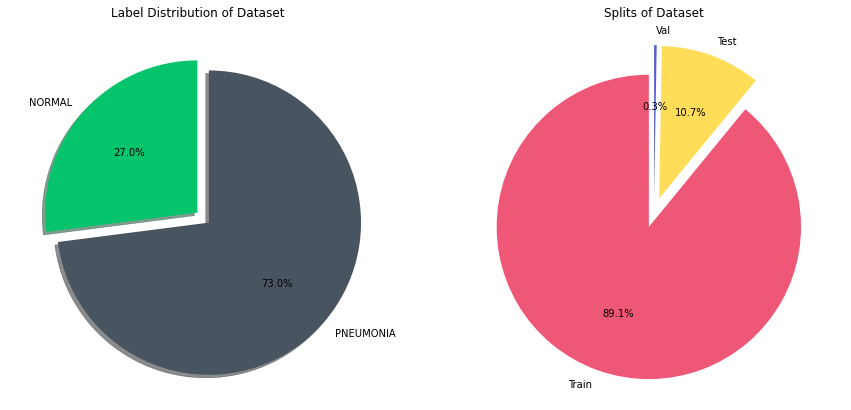

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
plt.style.use("ggplot")

axs[0].pie(x=[normal, pneumonia], 
        explode=(0, 0.1),
        colors=["#05c46b", "#485460"],
        labels=labels, 
        autopct="%1.1f%%", 
        shadow=True, 
        startangle=90,
        )
axs[0].title.set_text("Label Distribution of Dataset")

axs[1].pie(x=[train, test, val],
        labels=["Train", "Test", "Val"],
        explode=(0.1,0.1,0.1),
        colors=["#ef5777", "#ffdd59", "#575fcf"],
        autopct="%1.1f%%",  
        startangle=90,
       )
axs[1].title.set_text("Splits of Dataset")

plt.show();

In [6]:
def random_plot(label):

    path = os.path.join(train_dir, label)
    imgs = os.listdir(path)
    random_imgs = random.sample(imgs, 3)
    fig = plt.figure(figsize=(20,10))
    
    for i in range(len(random_imgs)):
        
        img_path = os.path.join(path, random_imgs[i])
        img = plt.imread(img_path)
        fig.add_subplot(1,3,i+1)
        plt.imshow(img, cmap="bone")

### Random Plot

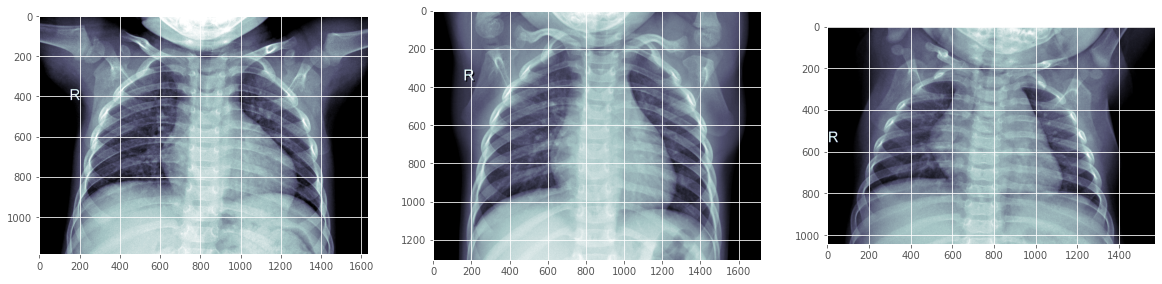

In [7]:
random_plot("NORMAL")

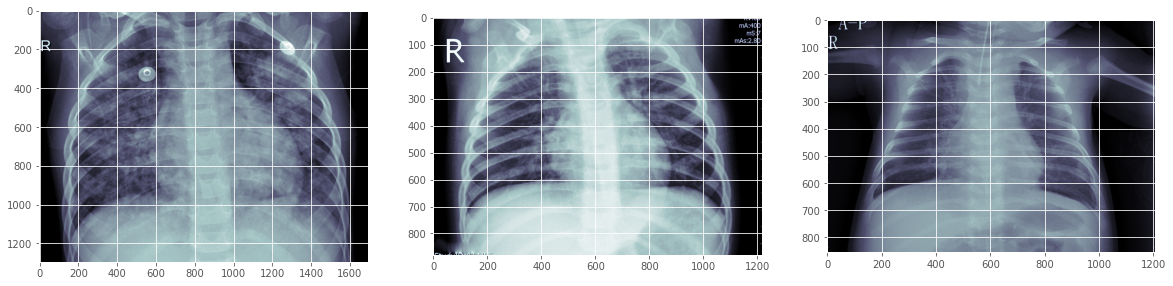

In [8]:
random_plot("PNEUMONIA")

### Canny Edge Detection

In [9]:
def canny(label):
    
    path = os.path.join(train_dir, label)
    imgs = os.listdir(path)
    random_imgs = random.sample(imgs, 3)
    fig = plt.figure(figsize=(20,10))
    
    for i in range(len(random_imgs)):
        
        img_path = os.path.join(path, random_imgs[i])
        img = plt.imread(img_path)
        fig.add_subplot(1,3,i+1)
        can = cv.Canny(img, 60, 60)
        plt.imshow(can)

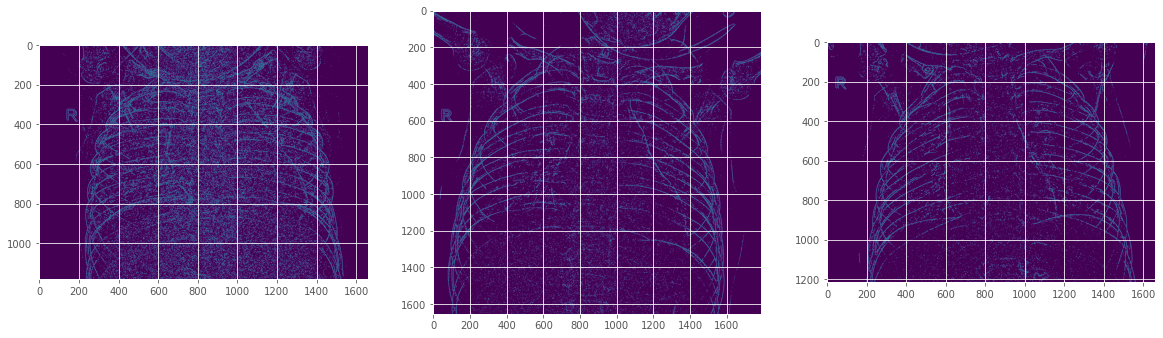

In [10]:
canny("NORMAL")

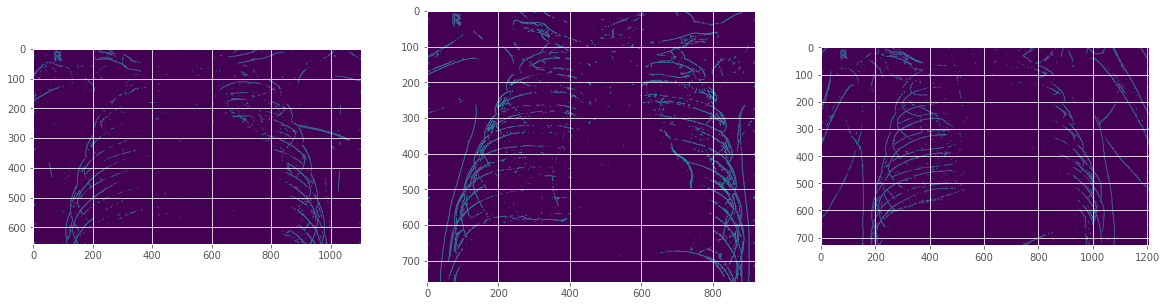

In [11]:
canny("PNEUMONIA")

# Data Generator<a id="generator"></a>
#### [Return2Contents](#contents)

In [12]:
train_datagen = ImageDataGenerator(
                                
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.6,1.2),
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    
    train_dir,
    target_size=(256,256),
    class_mode="binary",
    batch_size=16,
    shuffle=True,
    seed=44,
)

test_generator = test_datagen.flow_from_directory(
    
    test_dir,
    target_size=(256,256),
    class_mode="binary",
    batch_size=16,
    
)

val_generator = test_datagen.flow_from_directory(
    
    val_dir,
    target_size=(256,256),
    class_mode="binary",
    batch_size=8,
    
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Augmented Images

In [14]:
augmented = next(train_generator)

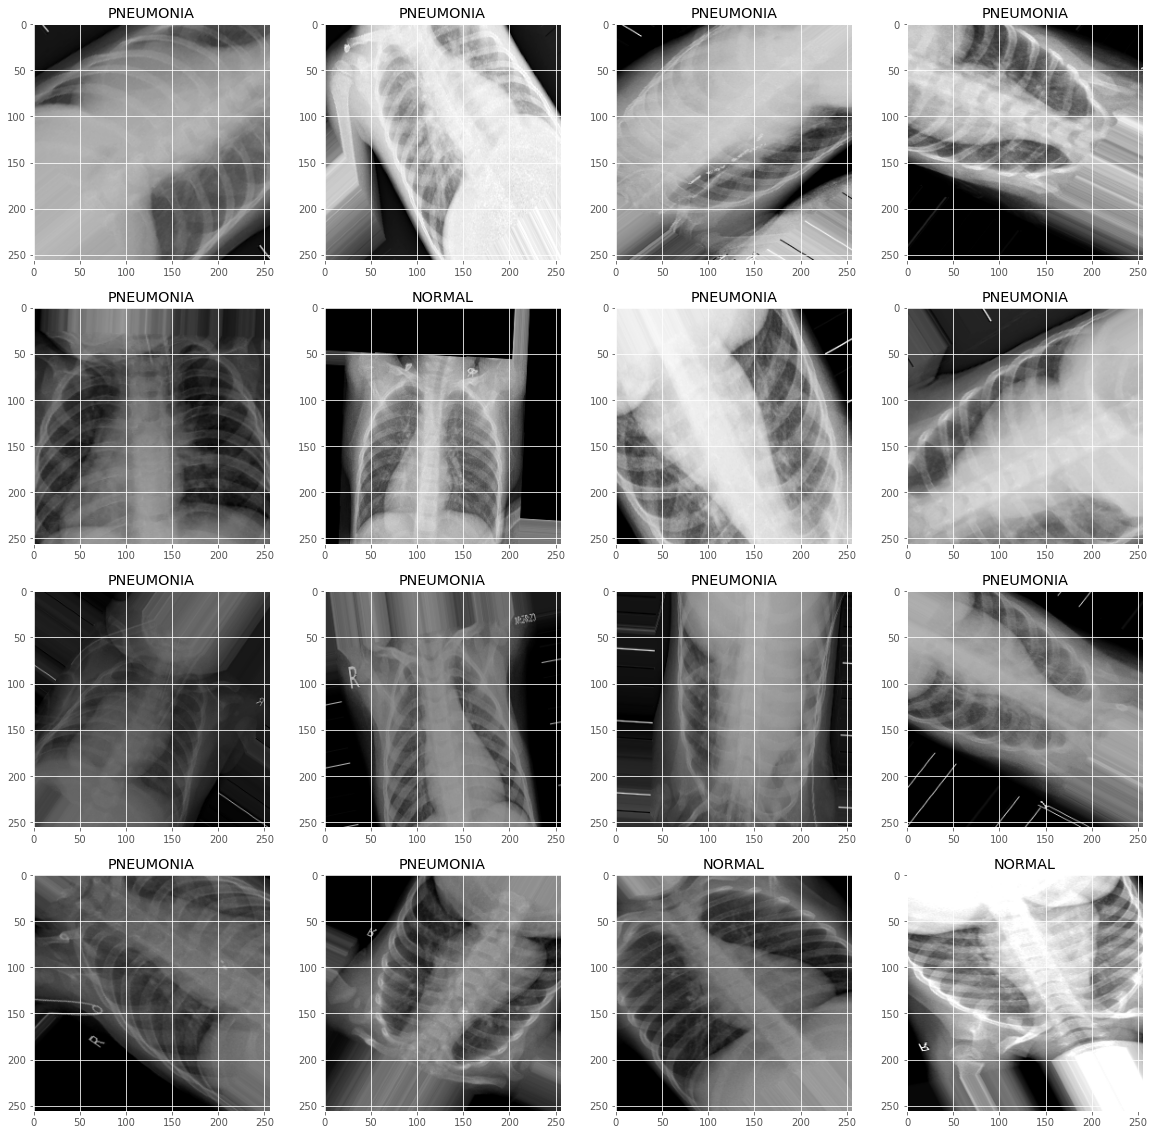

In [15]:
fig = plt.figure(figsize=(20,20))

for i in range(len(augmented[0])):
    
    img = augmented[0][i]
    label = augmented[1][i]
    
    fig.add_subplot(4,4,i+1)
    plt.imshow(img)
    
    if label == 0:
        plt.title("NORMAL")
    elif label == 1:
        plt.title("PNEUMONIA")

# Model<a id="model"></a>
#### [Return2Contents](#contents)

In [16]:
base_model = DenseNet169(
    
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
)

for layer in base_model.layers:
    layer.trainable = False
    

model = Sequential([
    
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid"),
])

model.summary()

51879936/51877672 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 8, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               213120    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 12,856,129
Trainable params: 213,249
Non-trainable params: 12,642,880
_________________________________________________________________


In [17]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])

es = EarlyStopping(monitor='accuracy', patience=4)
mc = ModelCheckpoint("./", monitor="accuracy", save_best_only=True)
rl = ReduceLROnPlateau(monitor="accuracy", factor=0.2, patience=2, min_lr=0.00001)

history = model.fit(
    
    train_generator, 
    validation_data=val_generator, 
    steps_per_epoch = 100, 
    epochs=20, 
    callbacks=[es,mc,rl],
)

Epoch 1/20
100/100 [==============================] - 67s 562ms/step - loss: 0.3852 - accuracy: 0.8248 - val_loss: 0.2691 - val_accuracy: 1.0000
Epoch 2/20
100/100 [==============================] - 52s 515ms/step - loss: 0.2150 - accuracy: 0.9182 - val_loss: 0.4470 - val_accuracy: 0.6875
Epoch 3/20
100/100 [==============================] - 50s 502ms/step - loss: 0.2256 - accuracy: 0.9030 - val_loss: 0.2712 - val_accuracy: 0.8125
Epoch 4/20
100/100 [==============================] - 49s 485ms/step - loss: 0.1969 - accuracy: 0.9250 - val_loss: 0.2963 - val_accuracy: 0.8125
Epoch 5/20
100/100 [==============================] - 55s 545ms/step - loss: 0.1760 - accuracy: 0.9281 - val_loss: 0.2242 - val_accuracy: 0.9375
Epoch 6/20
100/100 [==============================] - 57s 569ms/step - loss: 0.1891 - accuracy: 0.9197 - val_loss: 0.3564 - val_accuracy: 0.7500
Epoch 7/20
100/100 [==============================] - 59s 592ms/step - loss: 0.1872 - accuracy: 0.9221 - val_loss: 0.3233 - val_ac

# Results<a id="results"></a>
#### [Return2Contents](#contents)

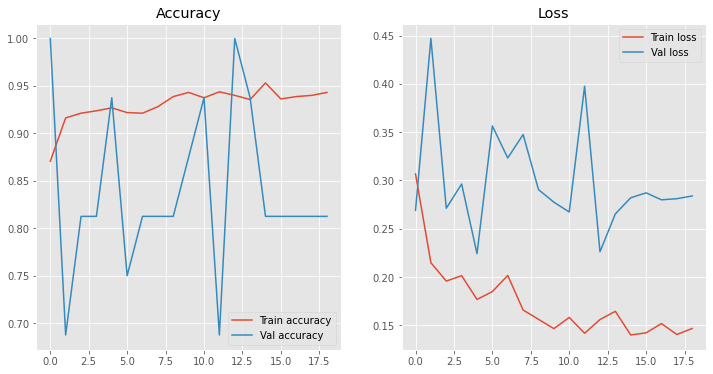

In [18]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Val accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(122)
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.title("Loss")
plt.legend();

In [19]:
model.evaluate(test_generator)

39/39 [==============================] - 9s 226ms/step - loss: 0.2692 - accuracy: 0.8910


[0.2691917419433594, 0.8910256624221802]